In [5]:
!pip install -q gdown

# kalian download semua file dari gdrive dibawah lalu buat folder (ex. midterm_folder)
!gdown --folder 1JvI5xhPfN3VmjpWYZk9fCHG41xG697um -O midterm_folder

Retrieving folder contents
Processing file 1ALveidCmKzk4p_liQ7b663BXL0PcTaFN test_transaction.csv
Processing file 1Ujh37a1kTarNf3dSOSrj-hKDswULebYA train_transaction.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1ALveidCmKzk4p_liQ7b663BXL0PcTaFN

but Gdown can't. Please check connections and permissions.


In [6]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import warnings

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

BASE_PATH = "midterm_folder"
train_transaction = pl.read_csv(f"{BASE_PATH}/train_transaction.csv", truncate_ragged_lines=True)
test_transaction = pl.read_csv(f"{BASE_PATH}/test_transaction.csv", truncate_ragged_lines=True)

print(f"Train shape: {train_transaction.shape}")
print(f"Test shape: {test_transaction.shape}")
print(f"Fraud rate in training: {train_transaction['isFraud'].mean():.4f}")

Using device: cpu
Train shape: (10852, 394)
Test shape: (11951, 393)
Fraud rate in training: 0.0266


In [ ]:
train_transaction.head() #isFraud adalah target featurenya

TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,…,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
i64,i64,i64,f64,str,i64,f64,f64,str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2987000,0,86400,68.5,"""W""",13926,null,150.0,"""discover""",142.0,"""credit""",315.0,87.0,19.0,null,null,null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,null,13.0,null,null,null,…,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987001,0,86401,29.0,"""W""",2755,404.0,150.0,"""mastercard""",102.0,"""credit""",325.0,87.0,null,null,"""gmail.com""",null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,null,null,0.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987002,0,86469,59.0,"""W""",4663,490.0,150.0,"""visa""",166.0,"""debit""",330.0,87.0,287.0,null,"""outlook.com""",null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,null,null,0.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987003,0,86499,50.0,"""W""",18132,567.0,150.0,"""mastercard""",117.0,"""debit""",476.0,87.0,null,null,"""yahoo.com""",null,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,null,…,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987004,0,86506,50.0,"""H""",4497,514.0,150.0,"""mastercard""",102.0,"""credit""",420.0,87.0,null,null,"""gmail.com""",null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,null,null,null,null,null,…,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_transaction.head() #uji data baru, setelah pembuatan model machine learningnya

TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,…,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
i64,i64,f64,str,i64,f64,f64,str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3663549,18403224,31.95,"""W""",10409,111.0,150.0,"""visa""",226.0,"""debit""",170.0,87.0,1.0,null,"""gmail.com""",null,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,null,null,…,0.0,0.0,1.0,0.0,47.950001,0.0,0.0,47.950001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663550,18403263,49.0,"""W""",4272,111.0,150.0,"""visa""",226.0,"""debit""",299.0,87.0,4.0,null,"""aol.com""",null,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,null,null,…,0.0,0.0,1.0,0.0,280.0,77.0,0.0,280.0,0.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663551,18403310,171.0,"""W""",4476,574.0,150.0,"""visa""",226.0,"""debit""",472.0,87.0,2635.0,null,"""hotmail.com""",null,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,null,null,…,0.0,0.0,1.0,0.0,1321.0,0.0,0.0,1058.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663552,18403310,284.95,"""W""",10989,360.0,150.0,"""visa""",166.0,"""debit""",205.0,87.0,17.0,null,"""gmail.com""",null,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663553,18403317,67.95,"""W""",18018,452.0,150.0,"""mastercard""",117.0,"""debit""",264.0,87.0,6.0,null,"""gmail.com""",null,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,null,null,…,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [7]:
class FraudDetectionNN(nn.Module):
    def __init__(self, input_size, hidden_layers=[256, 128, 64], dropout_rate=0.3):
        super(FraudDetectionNN, self).__init__()

        layers = []
        prev_size = input_size

        # Create hidden layers
        for hidden_size in hidden_layers:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(prev_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output(x)
        return self.sigmoid(x)

In [8]:
class FraudDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [9]:
class PyTorchFraudDetector:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.selected_features = None
        self.history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}

    def explore_data(self, df):
        """Explore the data structure"""
        print("=== Data Exploration ===")
        print(f"Shape: {df.shape}")
        print(f"Columns: {len(df.columns)}")

        # Check target distribution
        if 'isFraud' in df.columns:
            fraud_stats = df.group_by('isFraud').agg(pl.count())
            print(f"\nTarget distribution:")
            print(fraud_stats)

        return df

    def handle_missing_values(self, df, threshold=0.7):
        print(f"\n=== Handling Missing Values (threshold={threshold}) ===")

        total_rows = df.height
        missing_counts = df.null_count()

        # 1. Drop columns above threshold
        cols_to_drop = []
        for col in df.columns:
            if col == "isFraud":
                continue

            nulls = missing_counts[col][0]
            if nulls / total_rows > threshold:
                cols_to_drop.append(col)

        print(f"Dropping {len(cols_to_drop)} columns: {cols_to_drop}")
        df = df.drop(cols_to_drop)

        # 2. Fill numeric columns with median
        numeric_dtypes = [pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16, pl.Int8]
        numeric_cols = [c for c in df.columns if df[c].dtype in numeric_dtypes]

        for col in numeric_cols:
            median_val = df[col].median()
            if median_val is not None:
                df = df.with_columns(pl.col(col).fill_null(median_val))

        # 3. Fill string columns with "unknown"
        string_cols = [c for c in df.columns if df[c].dtype == pl.Utf8]

        for col in string_cols:
            df = df.with_columns(pl.col(col).fill_null("unknown"))

        print(f"Shape after cleaning: {df.shape}")
        return df


    def feature_engineering(self, df):
        """Create new features from existing data"""
        print("\n=== Feature Engineering ===")

        # Transaction amount features
        if 'TransactionAmt' in df.columns:
            df = df.with_columns([
                pl.col("TransactionAmt").log().alias("TransactionAmt_log"),
                (pl.col("TransactionAmt") / pl.col("TransactionAmt").mean()).alias("TransactionAmt_ratio")
            ])

        # Time-based features from TransactionDT
        if 'TransactionDT' in df.columns:
            df = df.with_columns([
                (pl.col("TransactionDT") % (24 * 3600) / 3600).alias("Hour"),
                ((pl.col("TransactionDT") // (24 * 3600)) % 7).alias("DayOfWeek"),
                (pl.col("TransactionDT") // (24 * 3600)).alias("DaysSinceStart")
            ])

        # Email features
        if 'P_emaildomain' in df.columns:
            df = df.with_columns([
                pl.col("P_emaildomain").is_not_null().cast(pl.Int64).alias("Has_P_email"),
                pl.col("P_emaildomain").str.contains("gmail|yahoo|hotmail").fill_null(False).cast(pl.Int64).alias("IsPopularEmail")
            ])

        if 'R_emaildomain' in df.columns:
            df = df.with_columns([
                pl.col("R_emaildomain").is_not_null().cast(pl.Int64).alias("Has_R_email")
            ])

        # Card features
        card_cols = [col for col in df.columns if 'card' in col.lower() and col not in ['card1', 'card2', 'card3']]
        if card_cols:
            card_presence = [pl.col(col).is_not_null() for col in card_cols]
            df = df.with_columns([
                pl.sum_horizontal(card_presence).alias("Card_Info_Count")
            ])

        print(f"Shape after feature engineering: {df.shape}")
        return df

    def select_features(self, max_features=100):
        """Select features for modeling"""
        print("\n=== Feature Selection ===")

        # Use a comprehensive set of features
        base_features = [
            'TransactionAmt', 'TransactionDT', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
            'addr1', 'addr2', 'dist1', 'dist2',
            'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
            'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15'
        ]

        # Add V features
        v_features = [f'V{i}' for i in range(1, 101)]

        # Add engineered features
        engineered_features = [
            'TransactionAmt_log', 'TransactionAmt_ratio', 'Hour',
            'DayOfWeek', 'DaysSinceStart', 'Has_P_email', 'Has_R_email',
            'IsPopularEmail', 'Card_Info_Count'
        ]

        potential_features = base_features + v_features + engineered_features

        self.selected_features = potential_features[:max_features]
        print(f"Selected {len(self.selected_features)} features")
        return self.selected_features

    def prepare_data(self, train_df, test_df=None, sample_frac=0.3):
        """Prepare data for modeling using only numeric features - FIXED VERSION"""
        print("\n=== Preparing Data (Numeric Only) ===")

        # Sample data for faster development
        if sample_frac < 1.0:
            train_df = train_df.sample(fraction=sample_frac, seed=42)
            print(f"Sampled training data: {train_df.shape}")

        # Select only numeric features
        numeric_cols = [
            col for col in train_df.columns
            if train_df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16, pl.Int8]
            and col not in ['isFraud', 'TransactionID']
        ]

        # Limit to top 100 numeric features
        self.selected_features = numeric_cols[:100]
        print(f"Selected {len(self.selected_features)} numeric features")

        # Prepare features and target
        features = self.selected_features + ['isFraud']

        # Convert to pandas and ensure we only use numeric columns
        train_data = train_df.select(features).to_pandas()

        # Separate features and target
        X = train_data[self.selected_features]
        y = train_data['isFraud']

        # Ensure all columns are numeric and handle missing values
        X = X.apply(pd.to_numeric, errors='coerce')  # Convert any non-numeric to NaN
        X = X.fillna(X.median())  # Now safely fill with median

        print(f"Original fraud rate: {y.mean():.4f}")

        # Apply SMOTE
        print("Applying SMOTE for class imbalance...")
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        print(f"After SMOTE - X: {X_resampled.shape}, y: {y_resampled.shape}")
        print(f"New fraud rate: {y_resampled.mean():.4f}")

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
        )

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(X_train)
        self.X_val_scaled = self.scaler.transform(X_val)

        # Convert to tensors
        self.X_train_tensor = torch.FloatTensor(self.X_train_scaled).to(device)
        self.X_val_tensor = torch.FloatTensor(self.X_val_scaled).to(device)
        self.y_train_tensor = torch.FloatTensor(y_train.values).to(device)
        self.y_val_tensor = torch.FloatTensor(y_val.values).to(device)

        print(f"Training set: {self.X_train_tensor.shape}")
        print(f"Validation set: {self.X_val_tensor.shape}")
        print(f"Fraud rate in training: {y_train.mean():.4f}")

        # Prepare test data if provided
        if test_df is not None:
            test_features = [col for col in self.selected_features if col in test_df.columns]
            self.X_test = test_df.select(test_features).to_pandas()

            # Ensure test data has same numeric processing
            self.X_test = self.X_test.apply(pd.to_numeric, errors='coerce')
            self.X_test = self.X_test.fillna(X.median())  # Use training median

            self.X_test_scaled = self.scaler.transform(self.X_test)
            self.X_test_tensor = torch.FloatTensor(self.X_test_scaled).to(device)
            print(f"Test set prepared: {self.X_test_tensor.shape}")

    def create_model(self, hidden_layers=[512, 256, 128, 64], dropout_rate=0.3):
        """Create the neural network model"""
        print("\n=== Creating Neural Network Model ===")
        input_size = self.X_train_tensor.shape[1]

        self.model = FraudDetectionNN(
            input_size=input_size,
            hidden_layers=hidden_layers,
            dropout_rate=dropout_rate
        ).to(device)

        print(f"Model architecture:")
        print(self.model)
        print(f"Total parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        return self.model

    def train_model(self, epochs=50, batch_size=1024, learning_rate=0.001):
        """Train the neural network model - FIXED VERSION"""
        print("\n=== Training Model ===")

        if self.model is None:
            self.create_model()

        # Create data loaders
        train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Define loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)

        # FIX: Remove 'verbose' parameter from ReduceLROnPlateau
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

        print(f"Training for {epochs} epochs with batch size {batch_size}")

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_predictions = []
            train_targets = []

            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self.model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_predictions.extend(outputs.detach().cpu().numpy())
                train_targets.extend(batch_y.cpu().numpy())

            # Validation phase
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(self.X_val_tensor).squeeze()
                val_loss = criterion(val_outputs, self.y_val_tensor)
                val_predictions = val_outputs.cpu().numpy()
                val_targets = self.y_val_tensor.cpu().numpy()

            # Calculate AUC scores
            train_auc = roc_auc_score(train_targets, train_predictions)
            val_auc = roc_auc_score(val_targets, val_predictions)

            # Store history
            self.history['train_loss'].append(train_loss / len(train_loader))
            self.history['val_loss'].append(val_loss.item())
            self.history['train_auc'].append(train_auc)
            self.history['val_auc'].append(val_auc)

            # Update learning rate - FIX: Add manual verbose output
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']

            if new_lr != old_lr:
                print(f"Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], '
                    f'Train Loss: {train_loss/len(train_loader):.4f}, '
                    f'Val Loss: {val_loss.item():.4f}, '
                    f'Train AUC: {train_auc:.4f}, '
                    f'Val AUC: {val_auc:.4f}, '
                    f'LR: {new_lr:.6f}')

    def evaluate_model(self, threshold=0.5):
        """Evaluate the trained model"""
        print("\n=== Model Evaluation ===")

        if self.model is None:
            print("No model trained yet!")
            return None

        self.model.eval()
        with torch.no_grad():
            val_outputs = self.model(self.X_val_tensor).squeeze()
            val_predictions = (val_outputs.cpu().numpy() > threshold).astype(int)
            val_probabilities = val_outputs.cpu().numpy()
            val_targets = self.y_val_tensor.cpu().numpy()

        # Calculate metrics
        auc_roc = roc_auc_score(val_targets, val_probabilities)

        print(f"AUC-ROC: {auc_roc:.4f}")
        print("\nClassification Report:")
        print(classification_report(val_targets, val_predictions))

        # Calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(val_targets, val_probabilities)

        results = {
            'AUC-ROC': auc_roc,
            'Predictions': val_predictions,
            'Probabilities': val_probabilities,
            'Precision': precision,
            'Recall': recall
        }

        self.results = results
        return results

    def plot_results(self):
        """Plot training history and evaluation results"""
        if not hasattr(self, 'results'):
            print("No results to plot. Run evaluate_model first.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot training history
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss')
        axes[0, 0].plot(self.history['val_loss'], label='Val Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        axes[0, 1].plot(self.history['train_auc'], label='Train AUC')
        axes[0, 1].plot(self.history['val_auc'], label='Val AUC')
        axes[0, 1].set_title('Training and Validation AUC')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('AUC')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Confusion matrix
        cm = confusion_matrix(self.y_val_tensor.cpu().numpy(), self.results['Predictions'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 0], cmap='Blues')
        axes[1, 0].set_title('Confusion Matrix')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('Actual')

        # Precision-Recall curve
        axes[1, 1].plot(self.results['Recall'], self.results['Precision'])
        axes[1, 1].set_title('Precision-Recall Curve')
        axes[1, 1].set_xlabel('Recall')
        axes[1, 1].set_ylabel('Precision')
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

    def predict_test_set(self, threshold=0.5):
        """Make predictions on test set"""
        if self.model is None:
            print("No model trained yet!")
            return None

        self.model.eval()
        with torch.no_grad():
            test_outputs = self.model(self.X_test_tensor).squeeze()
            test_predictions = (test_outputs.cpu().numpy() > threshold).astype(int)
            test_probabilities = test_outputs.cpu().numpy()

        # Create submission format
        submission = pd.DataFrame({
            'TransactionID': test_transaction['TransactionID'].to_list(),
            'isFraud': test_probabilities  # Using probabilities for better evaluation
        })

        return submission

    def save_model(self, filepath='fraud_detection_model.pth'):
        """Save the trained model"""
        if self.model is not None:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'scaler': self.scaler,
                'selected_features': self.selected_features,
                'history': self.history
            }, filepath)
            print(f"Model saved to {filepath}")

    def load_model(self, filepath='fraud_detection_model.pth'):
        """Load a trained model"""
        checkpoint = torch.load(filepath, map_location=device)
        self.scaler = checkpoint['scaler']
        self.selected_features = checkpoint['selected_features']
        self.history = checkpoint['history']

        # Recreate model architecture
        self.create_model()
        self.model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from {filepath}")

In [11]:
fraud_detector = PyTorchFraudDetector()

In [12]:
print("Exploring ...")
fraud_detector.explore_data(train_transaction)

Exploring ...
=== Data Exploration ===
Shape: (10852, 394)
Columns: 394


/tmp/ipython-input-1902894480.py:16: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  fraud_stats = df.group_by('isFraud').agg(pl.count())



Target distribution:
shape: (2, 2)
┌─────────┬───────┐
│ isFraud ┆ count │
│ ---     ┆ ---   │
│ i64     ┆ u32   │
╞═════════╪═══════╡
│ 0       ┆ 10563 │
│ 1       ┆ 289   │
└─────────┴───────┘


TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,…,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
i64,i64,i64,f64,str,i64,f64,f64,str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2987000,0,86400,68.5,"""W""",13926,null,150.0,"""discover""",142.0,"""credit""",315.0,87.0,19.0,null,null,null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,null,13.0,null,null,null,…,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987001,0,86401,29.0,"""W""",2755,404.0,150.0,"""mastercard""",102.0,"""credit""",325.0,87.0,null,null,"""gmail.com""",null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,null,null,0.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987002,0,86469,59.0,"""W""",4663,490.0,150.0,"""visa""",166.0,"""debit""",330.0,87.0,287.0,null,"""outlook.com""",null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,null,null,0.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987003,0,86499,50.0,"""W""",18132,567.0,150.0,"""mastercard""",117.0,"""debit""",476.0,87.0,null,null,"""yahoo.com""",null,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,null,…,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2987004,0,86506,50.0,"""H""",4497,514.0,150.0,"""mastercard""",102.0,"""credit""",420.0,87.0,null,null,"""gmail.com""",null,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,null,null,null,null,null,…,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2997847,0,328123,120.0,"""W""",14574,199.0,150.0,"""mastercard""",102.0,"""credit""",123.0,87.0,5.0,null,"""roadrunner.com""",null,2.0,2.0,0.0,0.0,3.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,18.0,2.0,370.0,370.0,31.0,475.0,31.0,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2997848,0,328131,210.95,"""W""",17188,321.0,150.0,"""visa""",226.0,"""debit""",299.0,87.0,9.0,null,"""anonymous.com""",null,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,127.0,127.0,80.0,null,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2997849,0,328137,500.0,"""R""",3998,399.0,150.0,"""american express""",223.0,"""credit""",264.0,87.0,null,null,"""yahoo.com""","""yahoo.com""",1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,null,null,null,null,null,…,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
fraud_detector.explore_data(test_transaction)

=== Data Exploration ===
Shape: (11951, 393)
Columns: 393


TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,…,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
i64,i64,f64,str,i64,f64,f64,str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3663549,18403224,31.95,"""W""",10409,111.0,150.0,"""visa""",226.0,"""debit""",170.0,87.0,1.0,null,"""gmail.com""",null,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,null,null,…,0.0,0.0,1.0,0.0,47.950001,0.0,0.0,47.950001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663550,18403263,49.0,"""W""",4272,111.0,150.0,"""visa""",226.0,"""debit""",299.0,87.0,4.0,null,"""aol.com""",null,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,null,null,…,0.0,0.0,1.0,0.0,280.0,77.0,0.0,280.0,0.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663551,18403310,171.0,"""W""",4476,574.0,150.0,"""visa""",226.0,"""debit""",472.0,87.0,2635.0,null,"""hotmail.com""",null,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,null,null,…,0.0,0.0,1.0,0.0,1321.0,0.0,0.0,1058.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663552,18403310,284.95,"""W""",10989,360.0,150.0,"""visa""",166.0,"""debit""",205.0,87.0,17.0,null,"""gmail.com""",null,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3663553,18403317,67.95,"""W""",18018,452.0,150.0,"""mastercard""",117.0,"""debit""",264.0,87.0,6.0,null,"""gmail.com""",null,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,null,null,…,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3675495,18798455,77.95,"""W""",6236,194.0,150.0,"""mastercard""",117.0,"""debit""",181.0,87.0,10.0,null,"""yahoo.com""",null,4.0,4.0,0.0,0.0,1.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,13.0,4.0,121.0,121.0,31.0,121.0,31.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3675496,18798459,200.0,"""R""",17321,111.0,150.0,"""visa""",226.0,"""debit""",472.0,87.0,null,null,"""gmail.com""","""gmail.com""",1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,null,null,null,null,null,null,…,1.0,1.0,1.0,200.0,200.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,200.0,200.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,200.0,200.0,200.0,0.0,0.0,0.0,200.0,200.0,200.0
3675497,18798463,35.95,"""W""",4515,369.0,150.0,"""mastercard""",224.0,"""debit""",181.0,87.0,13.0,null,"""yahoo.com""",null,8.0,8.0,0.0,0.0,7.0,5.0,0.0,0.0,6.0,0.0,6.0,0.0,57.0,8.0,0.0,null,null,253.0,7.0,null,null,…,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,n

In [14]:
print("Cleaning data...")
train_cleaned = fraud_detector.handle_missing_values(train_transaction, threshold=0.6)
test_cleaned = fraud_detector.handle_missing_values(test_transaction, threshold=0.6)

Cleaning data...

=== Handling Missing Values (threshold=0.6) ===
Dropping 204 columns: ['dist1', 'dist2', 'R_emaildomain', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 

In [15]:
print("Engineering features...")
train_features = fraud_detector.feature_engineering(train_cleaned)
test_features = fraud_detector.feature_engineering(test_cleaned)

Engineering features...

=== Feature Engineering ===
Shape after feature engineering: (10852, 198)

=== Feature Engineering ===
Shape after feature engineering: (11951, 233)


In [16]:
print("Preparing data for modeling...")
fraud_detector.prepare_data(train_cleaned, test_cleaned, sample_frac=0.3)

Preparing data for modeling...

=== Preparing Data (Numeric Only) ===
Sampled training data: (3255, 190)
Selected 100 numeric features
Original fraud rate: 0.0267
Applying SMOTE for class imbalance...
After SMOTE - X: (6336, 100), y: (6336,)
New fraud rate: 0.5000
Training set: torch.Size([5068, 100])
Validation set: torch.Size([1268, 100])
Fraud rate in training: 0.5000
Test set prepared: torch.Size([11951, 100])


In [17]:
print("Creating and training model...")
fraud_detector.create_model(hidden_layers=[512, 256, 128, 64], dropout_rate=0.3)
fraud_detector.train_model(epochs=100, batch_size=1024, learning_rate=0.001)

Creating and training model...

=== Creating Neural Network Model ===
Model architecture:
FraudDetectionNN(
  (hidden_layers): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
  )
  (output): Linear(in_fea

In [18]:
results = fraud_detector.evaluate_model()


=== Model Evaluation ===
AUC-ROC: 0.9994

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       634
         1.0       0.98      1.00      0.99       634

    accuracy                           0.99      1268
   macro avg       0.99      0.99      0.99      1268
weighted avg       0.99      0.99      0.99      1268



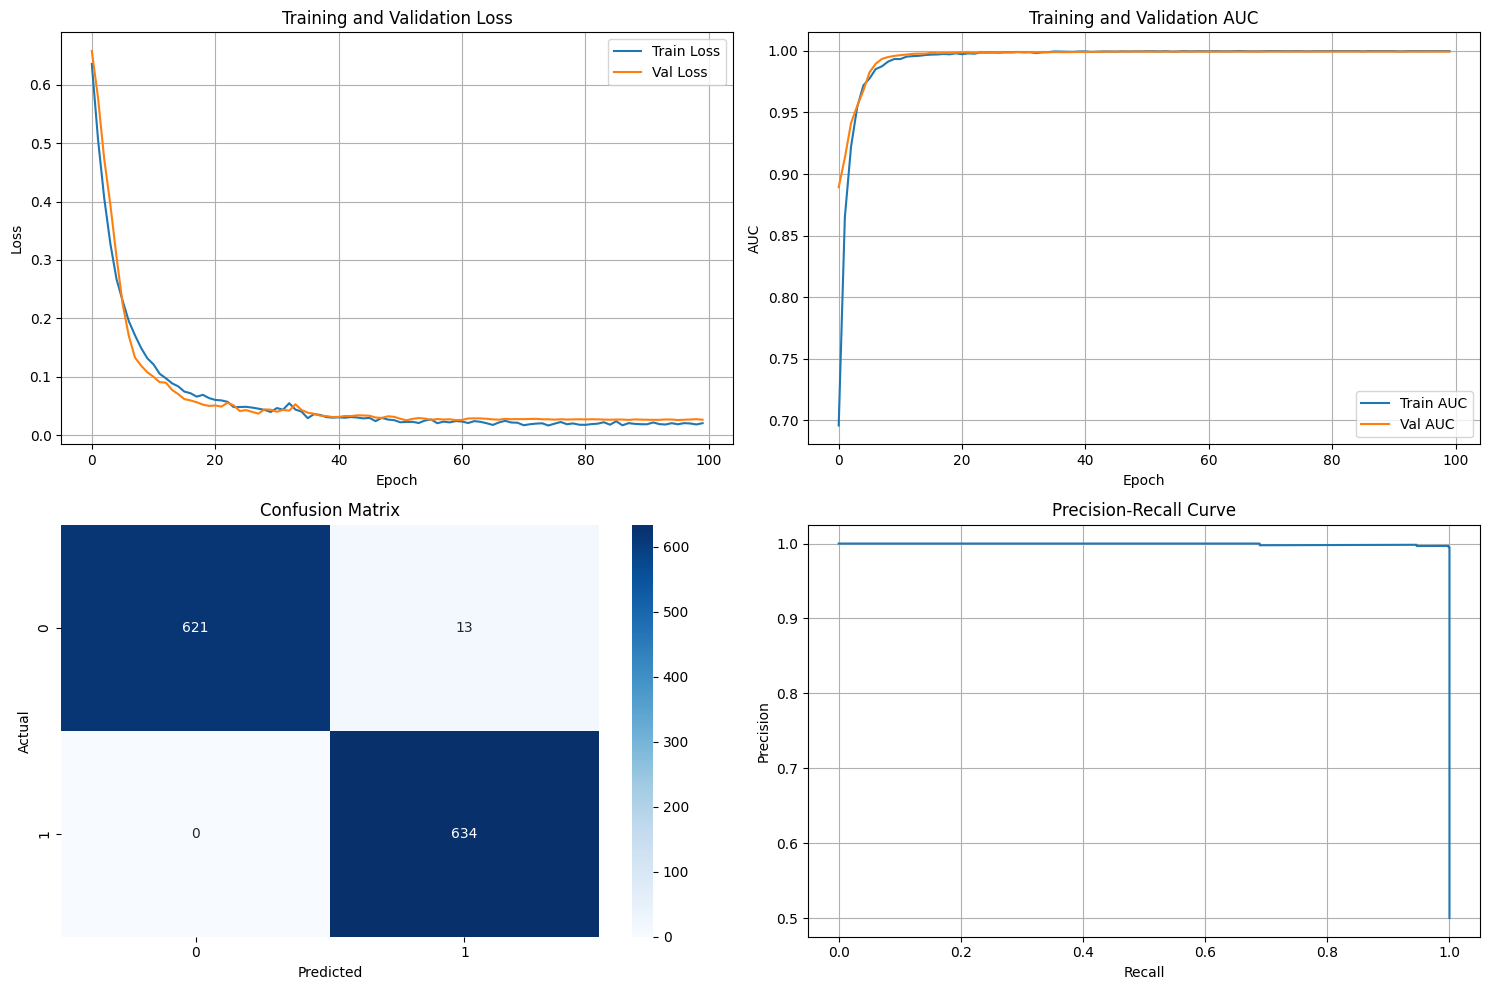

In [19]:
ffaud_detector.plot_results()

In [21]:
submission = fraud_detector.predict_test_set()

In [22]:
print(submission.head())

   TransactionID       isFraud
0        3663549  1.004050e-26
1        3663550  1.085310e-26
2        3663551  1.335163e-26
3        3663552  1.344239e-26
4        3663553  9.626689e-27
